In [9]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix, kde_1d
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as npb
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulator import simulate

In [10]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=17, threads_per_worker = 2)
client = Client(c,timeout=90)

In [11]:
# Read the study data into a dictionary
study_data_path = os.path.abspath('data/raw/adult_data.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data = {}
for row in reader:
   k, v = row
   study_data[k] = float(v)
study_data

{'1_5_Adults': 9446.1,
 '1_6_Adults': 6680.72,
 '1_8_Adults': 16291.1,
 '2_5_Adults': 23273.0,
 '2_6_Adults': 8159.24,
 '2_8_Adults': 13142.4,
 '3_5_Adults': 8104.48,
 '3_6_Adults': 23450.97,
 '3_8_Adults': 17947.59,
 '4_5_Adults': 5676.786667,
 '4_6_Adults': 11919.42667,
 '4_8_Adults': 17295.03333,
 '5_5_Adults': 6297.4,
 '5_6_Adults': 7885.44,
 '5_8_Adults': 21274.26,
 '6_5_Adults': 5667.66,
 '6_6_Adults': 19343.97,
 '6_8_Adults': 15127.45,
 '7_5_Adults': 11764.27333,
 '7_6_Adults': 13972.92667,
 '7_8_Adults': 13051.13333,
 '8_5_Adults': 8159.24,
 '8_6_Adults': 9126.666667,
 '8_8_Adults': 12631.30667,
 '9_5_Adults': 4709.36,
 '9_6_Adults': 9637.76,
 '9_8__Adults': 12375.76,
 '10_5_Adults': 5270.65,
 '10_6_Adults': 20493.93,
 '10_8_Adults': 13566.79}

In [12]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #transformed to 0.0001 - .1
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1),
              AILarvaSlope=(1, 9))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3),
              AIAdultLD50=(-4, -1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AIAdultSlope=(1, 9),
              AILarvaLD50=(-4,-1), #units are ug/bee. Equiv to .1 ng/bee to 100 ng/bee
              AILarvaSlope=(1, 9))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [13]:
# Set our distance function and sampler
distance = pyabc.PNormDistance(p=1)

sampler = DaskDistributedSampler(dask_client = client)
#sampler = SingleCoreSampler()

transition = LocalTransition()

In [16]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(100, max_population_size = 150),
             transitions = transition,
             sampler=sampler)

In [18]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_2_13.db"))
abc.new(db_path, study_data)

INFO:History:Start <ABCSMC(id=1, start_time=2019-02-13 15:45:29.779817, end_time=None)>
INFO:Epsilon:initial epsilon is 314356.7500059999


1

In [19]:
history = abc.run(max_nr_populations=2, minimum_epsilon=0)

INFO:ABC:t:0 eps:314356.7500059999
INFO:ABC:t:1 eps:272590.13334299996
INFO:Adaptation:Change nr particles 100 -> 150


KeyboardInterrupt: 

In [23]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2019-02-13 15:45:36.009119,0,0.000000,1
1,0,2019-02-13 16:14:36.904824,205,314356.750006,100


In [24]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}%".format(gen+1,particles/samples*100))

Acceptance rates
Gen 1: 48.8%


In [26]:
t = history.max_t
df, w = history.get_distribution(m=0, t=t)

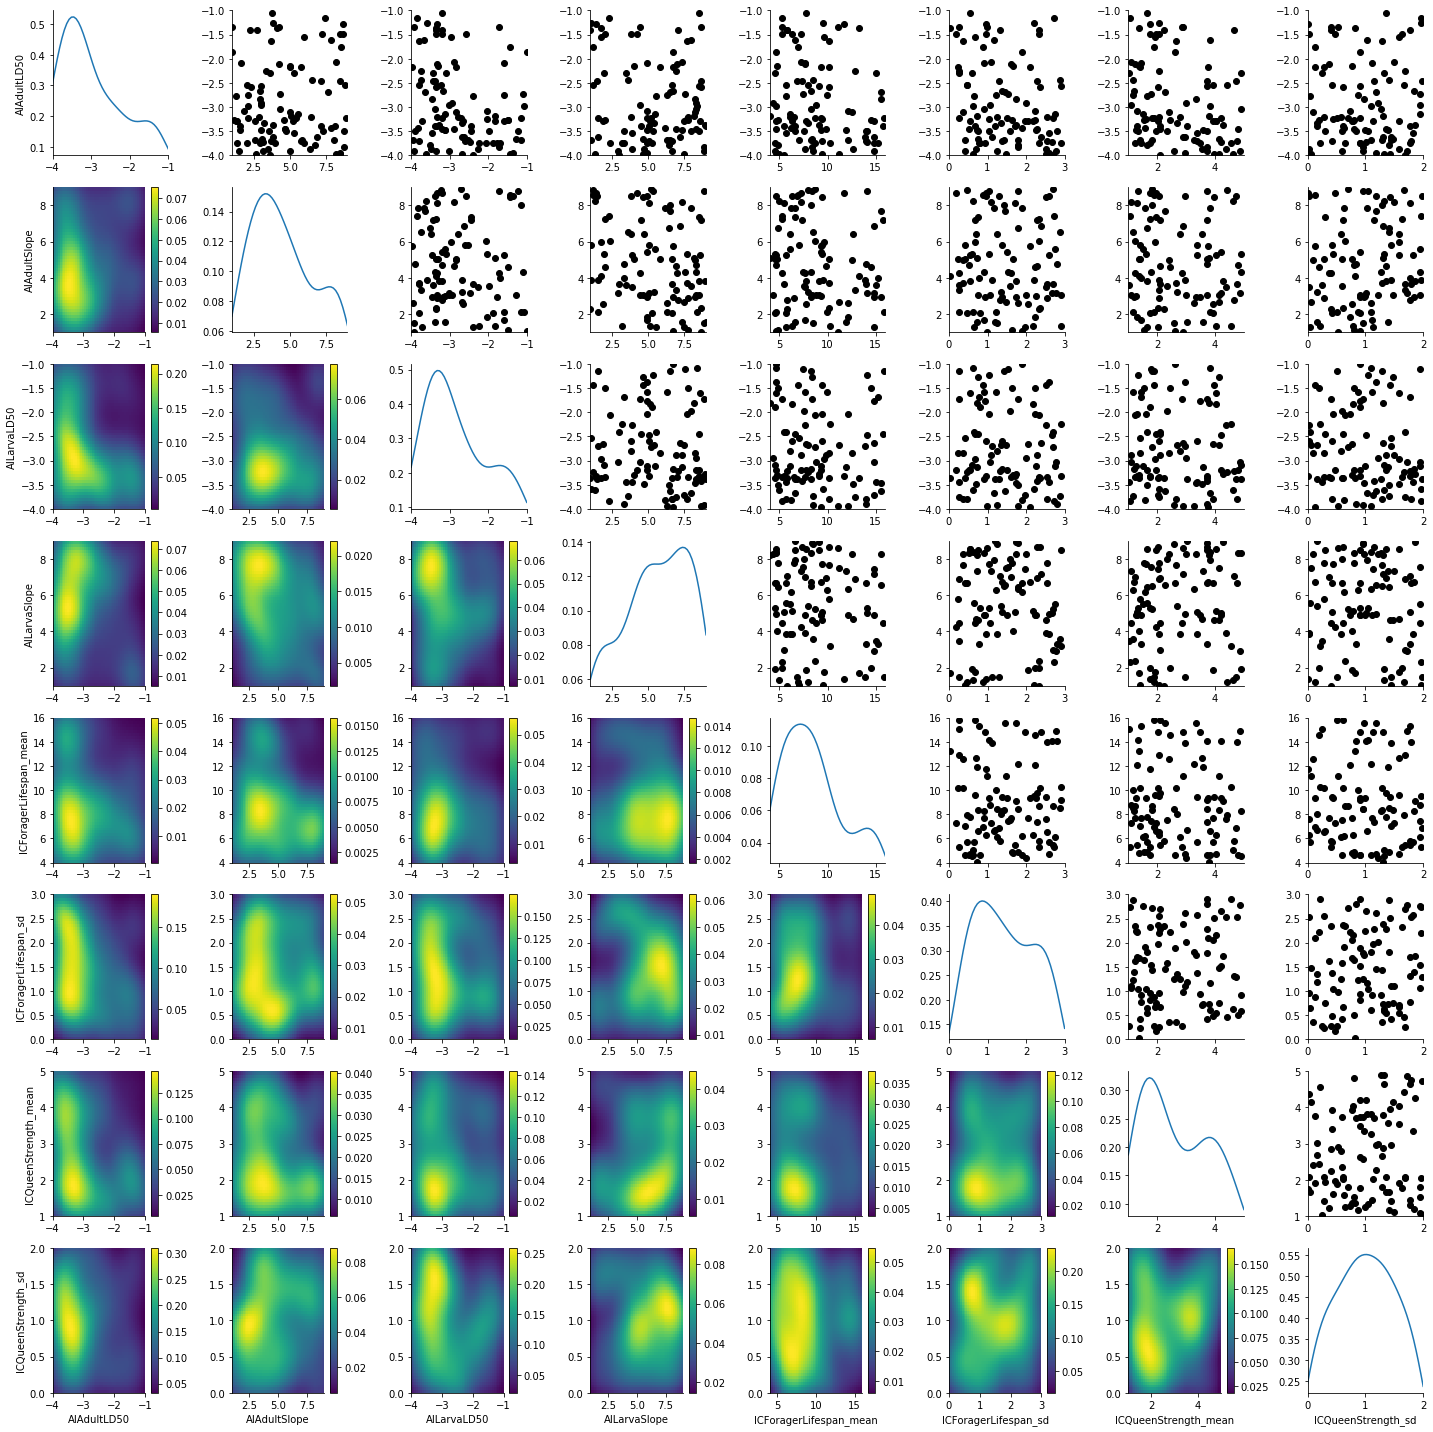

In [27]:
plot_kde_matrix(df, w, limits=limits);

### Load a stored run

In [22]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "test_2_13.db"))
history = History(db_path)
history.id = 1

In [2]:
pars = dict(ICQueenStrength_mean=3,
            ICQueenStrength_sd=1,
            ICForagerLifespan_mean=8,
            ICForagerLifespan_sd=2,
            AIAdultLD50=-2,
            AIAdultSlope=3,
            AILarvaLD50=-2,
            AILarvaSlope=3)

In [3]:
simulate(pars, save=True, logs=True)

Initial conditions:      site_code  per_corn  seams_bees_4    bees_cm2_4  capped_cm2_4  \
site                                                                 
1           BG        22     30.500000  12622.180000   7118.800000   
2           DS         1     16.000000  15332.800000   6571.200000   
3          FSR        49      7.500000   6653.340000   1820.770000   
4           HR        30      8.333333   5841.066667   2427.693333   
5           IB        22     15.500000   7803.300000   4243.900000   
6           MB        19      7.000000   3326.670000   2217.780000   
7           MO        39      7.666667   3787.566667   3084.813333   
8           SC         8     15.166667   7511.246667   3486.386667   
9           TV        31     10.000000   8953.260000     54.760000   
10          WB        30      9.000000   4545.080000   1971.360000   

       open_cm2_4  pollen_cm2_4  nectar_cm2_4      date_4  
site                                                       
1     6133.120000  

D:\Git_files\minucci_vp_mcmc\tools\DataSimulator.py:114: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  response_df = pd.DataFrame.from_items(zip(col_names,responses))


Initial conditions:      site_code  per_corn  seams_bees_4    bees_cm2_4  capped_cm2_4  \
site                                                                 
1           BG        22     30.500000  12622.180000   7118.800000   
2           DS         1     16.000000  15332.800000   6571.200000   
3          FSR        49      7.500000   6653.340000   1820.770000   
4           HR        30      8.333333   5841.066667   2427.693333   
5           IB        22     15.500000   7803.300000   4243.900000   
6           MB        19      7.000000   3326.670000   2217.780000   
7           MO        39      7.666667   3787.566667   3084.813333   
8           SC         8     15.166667   7511.246667   3486.386667   
9           TV        31     10.000000   8953.260000     54.760000   
10          WB        30      9.000000   4545.080000   1971.360000   

       open_cm2_4  pollen_cm2_4  nectar_cm2_4      date_4  
site                                                       
1     6133.120000  

Initial conditions:      site_code  per_corn  seams_bees_4    bees_cm2_4  capped_cm2_4  \
site                                                                 
1           BG        22     30.500000  12622.180000   7118.800000   
2           DS         1     16.000000  15332.800000   6571.200000   
3          FSR        49      7.500000   6653.340000   1820.770000   
4           HR        30      8.333333   5841.066667   2427.693333   
5           IB        22     15.500000   7803.300000   4243.900000   
6           MB        19      7.000000   3326.670000   2217.780000   
7           MO        39      7.666667   3787.566667   3084.813333   
8           SC         8     15.166667   7511.246667   3486.386667   
9           TV        31     10.000000   8953.260000     54.760000   
10          WB        30      9.000000   4545.080000   1971.360000   

       open_cm2_4  pollen_cm2_4  nectar_cm2_4      date_4  
site                                                       
1     6133.120000  

{'1_5_Adults': 56837,
 '1_6_Adults': 19845,
 '1_8_Adults': 18445,
 '2_5_Adults': 48335,
 '2_6_Adults': 19275,
 '2_8_Adults': 16568,
 '3_5_Adults': 15473,
 '3_6_Adults': 11853,
 '3_8_Adults': 15507,
 '4_5_Adults': 18803,
 '4_6_Adults': 9394,
 '4_8_Adults': 9118,
 '5_5_Adults': 36798,
 '5_6_Adults': 17944,
 '5_8_Adults': 20115,
 '6_5_Adults': 22091,
 '6_6_Adults': 21274,
 '6_8_Adults': 42845,
 '7_5_Adults': 22341,
 '7_6_Adults': 22261,
 '7_8_Adults': 37788,
 '8_5_Adults': 30022,
 '8_6_Adults': 18049,
 '8_8_Adults': 24808,
 '9_5_Adults': 1993,
 '9_6_Adults': 8586,
 '9_8_Adults': 6716,
 '10_5_Adults': 21412,
 '10_6_Adults': 6867,
 '10_8_Adults': 7288}